### Configure notebook
We first download and install necessary libraries.

In [1]:
# We use a CPU-based installation, but you can vary it easily from the PyG website:
# https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html
!pip install --user pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-1.13.0+cpu.html
DEPRECATION: gosam 2.1.1-4b98559 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of gosam or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: professor2 X.Y.Z has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of professor2 or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
!pip install --user git+https://github.com/alessiodevoto/jetgraphs.git

  Cloning https://github.com/alessiodevoto/jetgraphs.git to /tmp/pip-req-build-myjrt72v
  Running command git clone --filter=blob:none --quiet https://github.com/alessiodevoto/jetgraphs.git /tmp/pip-req-build-myjrt72v
  Resolved https://github.com/alessiodevoto/jetgraphs.git to commit 8e9096c22a137719151b2a1a6840f1098059dd57
  Preparing metadata (setup.py) ... done
  Using cached matplotlib-3.5.1-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.whl.metadata (6.7 kB)
Using cached matplotlib-3.5.1-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
DEPRECATION: gosam 2.1.1-4b98559 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of gosam or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: professor2 X.Y.Z has a non-standard version number. pip 24.0 will enforce this beh

# Download dataset 


#### 1. Define strategy to build edges
In order to have full control over the edges, we use our custom transform `jetgraphs.transforms.BuildEdges`. 
Through this, we can decide:

- `directed`: if the dataset should be directed
- `same_layer_threshold`: what is the maximum same layer distance to connect two nodes
- `consecutive_layer_threshold`: what is the maximum consecutive layer distance to connect two nodes
- `self_loop_weight`: what edge attribute to assign to self loops.
- `distance_p`: how should the distance between two nodes be computed? {1=manhattan, 2=euclidean}

Thanks to this transform, it's now easy to decide the graph building policy and test different settings, for instance the edge thresholds.

In [3]:
from jetgraphs.transforms import BuildEdges

edge_builder = BuildEdges(
    directed=False, 
    self_loop_weight=0,
    same_layer_threshold=0.6, 
    consecutive_layer_threshold=0.6,
    distance_p=2)

/cvmfs/sft.cern.ch/lcg/views/LCG_105/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch_geometric/typing.py:18: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.27' not found (required by /afs/desy.de/user/b/bauckhag/.local/lib/python3.9/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/cvmfs/sft.cern.ch/lcg/views/LCG_105/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch_geometric/typing.py:42: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.27' not found (required by /afs/desy.de/user/b/bauckhag/.local/lib/python3.9/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


#### 2. 🆕 🛑 Add optional transforms and filters (new feature)

We can now use filters during the processing of graphs. A filter is a boolean class that, given a graph, returns True if that graph should be included in the dataset, else False. We apply filters at two stages: before **pre_transform** and before **transform**, like shown in image here. 

Filter are the best way to exclude graphs based on their number of nodes. Graphs are filtered and pre transformed at processing stage. `pre_filter`, `pre_transform`, `post_filter` and `transform` are all provided as arguments to JetGraphDataset class.

Filters are found in `jetgraphs.transforms`.

![](https://drive.google.com/uc?export=view&id=1QHc4hJlZGm3xI5NlRs3Ci0Fz2sOAgqoS)



In [4]:
from jetgraphs.transforms import GraphFilter 

graph_filter = GraphFilter(min_num_nodes=2) # only graphs with at least 3 nodes will be accepted

Optionally, we can also add other transforms. All transforms are found in `jetgraphs.transforms`.

Here we just use `NumLayers` and `LayersNum`, that respectively add to each data object the number of layers and the ids of layers (e.g. [1,4] ) found in that graph.

In [5]:
from torch_geometric.transforms import Compose 
from jetgraphs.transforms import NumLayers, LayersNum

optional_transforms = Compose([NumLayers(), LayersNum()])


#### 3. Download dataset
🛑 Remark: After the inital download and preprocessing (this url is slower than the others), a saved preprocessed version is kept on disk, so that any further processing will be much quicker.


We can download and build the dataset like so:


In [6]:
!rm -rf content/jetgraph_dataset

In [7]:
!pwd

/nfs/dust/atlas/user/bauckhag/code/DESY-ATLAS-BSM/nn_studies/source


In [8]:
import h5py
import os

#loop over every file in ../data/GNN/Signal_v6
dir = "/nfs/dust/atlas/user/bauckhag/code/DESY-ATLAS-BSM/nn_studies/data/GNN/raw/Signal_v6/"
for file in os.listdir(dir):
    hdf5_file = h5py.File(dir+file, 'r')
    keys = list(hdf5_file.keys())
    print("File: ", file, keys)
    dataset = hdf5_file[keys[0]]
    print(dataset.shape, dataset[0].shape, dataset[0][0].shape)
    print(dataset[0][50001])

File:  a0_tupleGraph_barphi.h5 ['data']
(1,) (14129955,) ()
134
File:  a2_tupleGraph_barenergy.h5 ['data']
(1,) (14129955,) ()
134
File:  a3_tupleGraph_barlayer.h5 ['data']
(1,) (11018354,) ()
4
File:  a1_tupleGraph_barlayer.h5 ['data']
(1,) (11018354,) ()
4
File:  a2_tupleGraph_barpos3.h5 ['data']
(1,) (18575107,) ()
71
File:  a3_tupleGraph_barpos3.h5 ['data']
(1,) (18575107,) ()
71
File:  a0_tupleGraph_barenergyabs.h5 ['data']
(1,) (14129955,) ()
134
File:  a2_tupleGraph_barenergyabs.h5 ['data']
(1,) (14129955,) ()
134
File:  a2_tupleGraph_bareta.h5 ['data']
(1,) (14129955,) ()
134
File:  a2_tupleGraph_barpos4.h5 ['data']
(1,) (22575742,) ()
48
File:  a0_tupleGraph_barlayer.h5 ['data']
(1,) (11018354,) ()
4
File:  a1_tupleGraph_barenergyabs.h5 ['data']
(1,) (14129955,) ()
134
File:  a1_tupleGraph_barpos3.h5 ['data']
(1,) (18575107,) ()
71
File:  a3_tupleGraph_barphi.h5 ['data']
(1,) (14129955,) ()
134
File:  a0_tupleGraph_barpos4.h5 ['data']
(1,) (22575742,) ()
0
File:  a0_tupleGraph

In [9]:
from jetgraphs.JetGraphDataset import JetGraphDatasetInMemory_v2

#datasets_root = "content/jetgraphdataset"
datasets_root = "../data/GNN"
raw_data_url = "https://cernbox.cern.ch/s/PYurUUzcNdXEGpz/download"

jet_graph_dataset = JetGraphDatasetInMemory_v2(
    root = datasets_root,           # directory where to download data 
    url = raw_data_url,             # url to raw data
    subset = '10%',                # which subset of the intial 100k graph to consider, default is 100%
    pre_filter = graph_filter,      
    pre_transform = edge_builder,   # edge_builder should be passed as pre_transform to keep data on disk.
    post_filter = graph_filter,
    transform = optional_transforms,
    verbose=True
    ) 

Loaded dataset containing subset of 10%


In [10]:
# now graphs have a unique id, assigned only once before any other operation is performed
# ids are the same across different versions of datasets
jet_graph_dataset[101]

Data(x=[6, 4], y=[1], id='102', edge_attr=[22, 1], edge_index=[2, 22], num_layers=4, layers_num='[0, 1, 2, 3]')

In [11]:
# only 486 graphs out of the initial 500 have been accepted
jet_graph_dataset

JetGraphDatasetInMemory_v2(19931)

#### 4. New graph plotting function
The new function to plot a single graph offers a lot of new features. 
Most important are:
- we can control the angle and elevation of the plot (i.e. change the point of view) (`elev` and `angle`)
- we can decide whether higher energy nodes should be bigger in the plot (`energy_is_size`) 
- we can draw nodes belonging to differnt layers in different colors `color_layers`


In [12]:
g = jet_graph_dataset[50]
g

Data(x=[11, 4], y=[1], id='51', edge_attr=[89, 1], edge_index=[2, 89], num_layers=4, layers_num='[0, 1, 2, 3]')

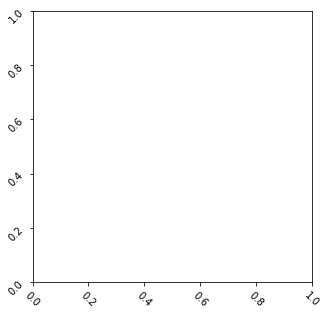

In [13]:
from jetgraphs.utils import plot_jet_graph

plot_jet_graph(
    g, 
    angle=30, 
    elev=10, 
    color_layers=True,
    energy_is_size=True,
    save_to_path="test.png")

In [14]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

# Create the dataloaders.
train_idx, test_idx = train_test_split(range(len(jet_graph_dataset)), stratify=[m.y[0].item() for m in jet_graph_dataset], test_size=0.2, random_state=77)
#train_loader = DataLoader(jet_graph_dataset[train_idx], batch_size=32, shuffle=True)#Alessio
#test_loader = DataLoader(jet_graph_dataset[test_idx], batch_size=32)#Alessio
train_loader = DataLoader(jet_graph_dataset[train_idx], batch_size=512, num_workers= 96, shuffle=True)
test_loader = DataLoader(jet_graph_dataset[test_idx], batch_size=512, num_workers= 96)
#from JetGraphDataset import stats
jet_graph_dataset.stats()

/cvmfs/sft.cern.ch/lcg/views/LCG_105/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 96 worker processes in total. Our suggested max number of worker in current system is 20, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



*** JetGraph Dataset ***

Number of classes: 2
Number of graphs: 19931
Dataset is directed: False
Number of node features: 4
Number of edge features: 1
Number of positive samples:9941.00


In [15]:
#from JetGraphDataset import stats
jet_graph_dataset.stats()
# Instantiate a model. 
# We take it from jetgraphs.models, but it can be any model for pytorch lightning.
from jetgraphs.models import Shallow_GCN
from jetgraphs.models import Residual_Arma, GAT, Arma
model = Arma(hidden_channels=256,node_feat_size=jet_graph_dataset[0].x.shape[1], use_edge_attr= False)
#model = Shallow_GCN(batch_size=32, hidden_channels=32, node_feat_size=jet_graph_dataset[0].x.shape[1])
model 
train_dataset = jet_graph_dataset[train_idx]
test_dataset = jet_graph_dataset[test_idx]


*** JetGraph Dataset ***

Number of classes: 2
Number of graphs: 19931
Dataset is directed: False
Number of node features: 4
Number of edge features: 1
Number of positive samples:9941.00


2024-04-02 14:55:24.368609: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/cvmfs/sft.cern.ch/lcg/views/LCG_105/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


In [16]:
#ignore deprecation warnings
import warnings

import pytorch_lightning as ptlight
from pytorch_lightning import loggers as pl_loggers
from jetgraphs.utils import plot_jet_graph, plot_metrics
import torch
# Provide directory to store checkpoints and train.
chkpt_dir = './checkpoints/'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Add LearningRateMonitor
lr_monitor = ptlight.callbacks.LearningRateMonitor(logging_interval='step')

# We save checkpoints every epoch 
checkpoint_callback = ptlight.callbacks.ModelCheckpoint(
    dirpath=chkpt_dir,
    filename='gcn-{epoch:02d}',
    every_n_epochs=5,
    save_top_k=-1)

EarlyStop = ptlight.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.00, patience=7, verbose=True, mode="min")

# Define trainer.
epochs = 20
trainer = ptlight.Trainer(
    #devices=1 if str(device).startswith("cuda") else 0,
    #accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    default_root_dir='./', 
    max_epochs=epochs, 
    callbacks=[checkpoint_callback, lr_monitor, EarlyStop],
    enable_progress_bar=True,
    log_every_n_steps=5,
    check_val_every_n_epoch=5)

# Train model.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    trainer.fit(model, train_loader, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | loss  | BCEWithLogitsLoss | 0     
1 | norm  | BatchNorm         | 8     
2 | conv1 | ARMAConv          | 203 K 
3 | conv2 | ARMAConv          | 590 K 
4 | conv3 | ARMAConv          | 590 K 
5 | lin0  | Linear            | 65.8 K
6 | lin   | Linear            | 257   
--------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.803     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Metric val_loss improved. New best score: 0.376


Validation: |                                                                                                 …

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.359


Validation: |                                                                                                 …

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.340


Validation: |                                                                                                 …

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.323
`Trainer.fit` stopped: `max_epochs=20` reached.


In [17]:
import numpy as np
import sklearn.metrics
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import warnings
import jetgraphs
from jetgraphs.utils import plot_jet_graph, plot_metrics
from jetgraphs.models import Arma
from torch_geometric.loader import DataLoader



# Predict.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pretrained_filename = f'./checkpoints/gcn-epoch=19.ckpt'
    model = Arma.load_from_checkpoint(pretrained_filename)
    full_loader = DataLoader(jet_graph_dataset, batch_size=512, num_workers=96)

    weights = trainer.predict(model, full_loader)
    truths = []

for data in jet_graph_dataset:
    truths.append((data['y'].unsqueeze(1).float()).tolist())

weights = np.array(sum(weights, []))
truths = np.array(sum(truths, []))



Predicting: |                                                                                                 …

Accuracy GNN:            0.8588
Precision (purity) GNN:  0.8859
Recall (efficiency) GNN: 0.8229


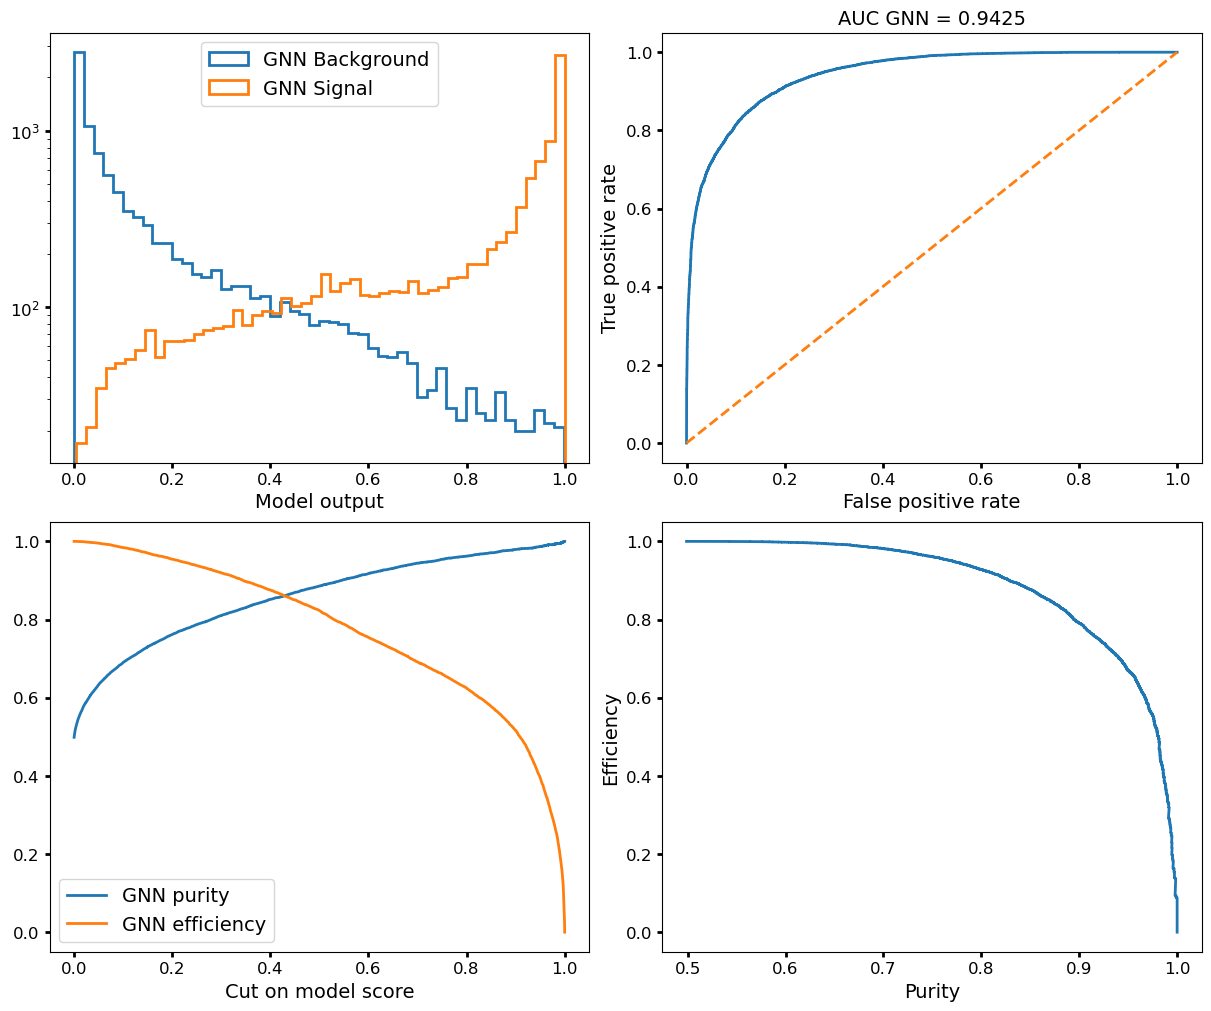

In [20]:
#plot metrics
y_pred1, y_true1 = (weights > 0.5), (truths > 0.5)
y_pred1_, y_true1_ = [0 if i == False else 1 for i in y_pred1], [0 if i == False else 1 for i in y_true1]
accuracy1  = sklearn.metrics.accuracy_score(y_true1, y_pred1)
precision1 = sklearn.metrics.precision_score(y_true1, y_pred1)
recall1    = sklearn.metrics.recall_score(y_true1, y_pred1)

print('Accuracy GNN:            %.4f' % accuracy1)
print('Precision (purity) GNN:  %.4f' % precision1)
print('Recall (efficiency) GNN: %.4f' % recall1)


fpr1, tpr1, _ = sklearn.metrics.roc_curve(y_true1, weights)


fig, axs = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)
axs = axs.flatten()
ax0, ax1, ax2, ax3 = axs

# Plot the model outputs
# binning=dict(bins=50, range=(0,1), histtype='step', log=True)
binning=dict(bins=50, histtype='step', log=True)
ax0.hist(weights[y_true1==False], lw=2, label='GNN Background', **binning)
ax0.hist(weights[y_true1], lw=2, label='GNN Signal', **binning)
ax0.set_xlabel('Model output', fontsize=14)
#ax0.set_title('Accuracy = %.4f' % accuracy, fontsize=14)
ax0.tick_params(width=2, grid_alpha=0.5, labelsize=12)
ax0.legend(loc=0, fontsize=14)

# Plot the ROC curve
auc1 = sklearn.metrics.auc(fpr1, tpr1)
ax1.plot(fpr1, tpr1, lw=2)
ax1.plot([0, 1], [0, 1], '--', lw=2)
ax1.set_xlabel('False positive rate', fontsize=14)
ax1.set_ylabel('True positive rate', fontsize=14)
ax1.set_title('AUC GNN = %.4f' % (auc1), fontsize=14)
ax1.tick_params(width=2, grid_alpha=0.5, labelsize=12)

p1, r1, t1 = sklearn.metrics.precision_recall_curve(y_true1, weights)
ax2.plot(t1, p1[:-1], label='GNN purity', lw=2)
ax2.plot(t1, r1[:-1], label='GNN efficiency', lw=2)
ax2.set_xlabel('Cut on model score', fontsize=14)
#ax2.set_title('Purity (Precision) = %.4f' % precision, fontsize=14) 
ax2.tick_params(width=2, grid_alpha=0.5, labelsize=12)
ax2.legend(fontsize=14)

ax3.plot(p1, r1, label='GNN', lw=2)
ax3.set_xlabel('Purity', fontsize=14)
ax3.set_ylabel('Efficiency', fontsize=14)
#ax3.set_title('Efficiency (Recall) = %.4f' % recall, fontsize=14)
ax3.tick_params(width=2, grid_alpha=0.5, labelsize=12)

plt.show()

In [19]:
weights

array([[0.97993124],
       [0.98808742],
       [0.94510657],
       ...,
       [0.14401539],
       [0.15197951],
       [0.46711197]])